In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Next word prediction


# Introduction

### Mathematical explanation of our goal

Our goal is to, given an input of sequence of words, predict what the most likely next word is.

In our case, a single word will be predicted, although predict more words is certainly possible. Single word is useful since it is more close to the autocomplete feature and accuracy is higher given a smaller dataset. Since we want to generate sequences longer than just 1 word, we will predict the next word and then use that predicted next word and append it to the previous input sequence. Using that newly updated input sequence we will be able to generate the next word in the sequence. This process can be repeated to generate as many sequence as we would like.

To demonstrate, let's say that the number of features/words we predict on is 3 and our initial input sequence is ["today", "was", "a"] and our goal is to predict the next 2 words. Let us assume that our model predicted the next word in the sequence to be "good" giving us the total sequence to be ["today", "was", "a", "good"]. We can now move the sliding window of size 3 to use the last 3 words of this (we added "good" to the end of the input sequence and dropped "today"). We now use this new input sequence ["was", "a", "good"] to predic the next word which would ideally be ["day"] fulfilling Ice Cube's lyrics. However, it is entirelly possible that some other word could be predicted such as ["boy"]. This is entirely dependent on the distribution learned from the training data. "was a good boy" makes sense, however, "today was a good boy" does not, which is why we will use much larger sequences of words (around 50) to predict the next word.

Essentially, the goal of the model is to learn and mimic from the training data as best as possible the probability distribution of the next word, given the previous words in the sequence - this is done through Bayes' theorem

We can represent this as:

$P(w_{t+1} | w_1, w_2, ..., w_{t})$

where $w_{t+1}$ is the target word we want to predict, and $w_1$, $w_2$, ..., $w_{t}$ are the previous words in the sequence. $w_{t+1}$ can be any of the words in the vocabulary $V$. Vocabulary is the set of all possible words that can be predicted.

Our goal is to find the word $w_{t+1}$ that maximizes the probability of the next word given the previous words. To do this, we find need to find the probability distribution for each word in the vocabulary.

We can express this probability through the chain rule of probability by multiplying the probabilities of each word in the sequence:
* Probability of the first word in the sequence being $w_1$ = $P(w_1)$
* Probability of the second word in the sequence being $w_2$ given that the first word in the sequence is $w_1$ = $P(w_2 | w_1)$
* Probability of the third word in the sequence being $w_3$ given that the first two words in the sequence are $w_1$ and $w_2$ = $P(w_3 | w_1, w_2)$

In general, we have the probability that the word $w_i$ is word i, given that first i-1 words in the sequence are $w_1, w_2, ..., w_{i-1}$


$ P(w(1), w(2), ..., w(i)) = P(w(1)) \times P(w(2) | w(1)) \times P(w(3) | w(1), w(2)) \times ... \times P(w(i) | w(1), w(2), ..., w(i-1)) = \Pi_{t=1}^{T} P(w_{t} | w_{t},...,w_{1})$









### Pipeline

Below is the general overview of the project pipeline. Individual choices and decisions are explained in the corresponding sections.

1. Get data
    1. Keylogs
        1. Use keylogger to record keystrokes
        2. Merge keylogs into one file
    2. Books and articles from Project Gutenberg
        1. Download books and articles
        2. Merge books and articles into one file
<br><br>
2. Data processing
    1. Lowercase
    2. Single whitespace
    3. Remove punctuation
    4. Remove numbers
    5. Widen contractions
    6. (keylogs) Fix typos
    7. (keylogs) Remove emojis
    8. [optional] (keylogs) Remove non-English
    9. Remove stopwords
    9. Split into tokens
    10. Lemmatize or Stem (Lemmatize preferred)
<br><br>
3. Tokenization
<br><br>
4. Create features and target sequences (N-grams)
<br><br>
5. Split into train, validation, and test sets
    1. Train: 80%
    2. Validation: 10%
    3. Test: 10%
<br><br>
6. Vectorization - Creating an embedding matrix from GloVe
<br><br>
7. Creating an LSTM sequential model
<br><br>
8. Evaluation
    1. Perplexity
    2. Word similarity
<br><br>
9. Prediction - Generating sequences

Necessary installs:
1. pip instal TextBlob
2. pip install tensorflow (or tensorflow-gpu) and keras
3. pip install nltk
4. pip install git+https://github.com/MCFreddie777/language-check.git
5. pip install contractions
6. pip install pycontractions
7. pip install numpy
8. pip install scikit-learn
9. pip install pandas
10. pip install matplotlib
11. pip install regex
12. pip install pynput
13. pip install win32gui
14. pip install fuzzywuzzy

### Reading the data

#### Merging text files / keylogger logs

Given that the keylogger has been running for a few days or that there are several books, the txt files have to be merged into a single txt file.

In [29]:
def merge_txt_files(input_dir=".\keylogger\logs", output_dir="database/merged", name="master.txt"):
    """Merges all .txt files in the input directory into a single .txt file in the output directory.

    Parameters
    ----------
    input_dir : str
        The path to the directory containing the .txt files to merge. Defaults to ".\keylogger\logs".
    output_dir : str
        The path to the directory where the merged 'master.txt' file will be saved. Defaults to "database".

    Returns
    -------
    None
    """

    import os

    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        print(
            "Creating a folder '{output_dir}' to store the merged text file...")
        os.makedirs(output_dir)

    # Merge the contents of all .txt files in the input directory into a single string
    merged_text = ""
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(input_dir, filename), "r") as f:
                merged_text += f.read()
    print(
        f"Merged all .txt files from the {input_dir} folder into a single variable.")

    # Write the merged text to a new file in the output directory
    output_filename = os.path.join(output_dir, name)
    with open(output_filename, "w") as f:
        f.write(merged_text)
    print(f"Saved the merged text to ./{output_filename}")


In [30]:
merge_txt_files(input_dir = '/content/drive/MyDrive/PredictNextWords/database/hp_unprocessed')

Merged all .txt files from the /content/drive/MyDrive/PredictNextWords/database/hp_unprocessed folder into a single variable.
Saved the merged text to ./database/merged/master.txt


#### Reading the master text file

Below is the function used to read a text file and return a string containing the entire dataset which we use in our preprocessing.

In [3]:
def read_txt_file(file_name, folder_path="/content/drive/MyDrive/PredictNextWords/database/processed/"):
    """Reads a text file.

    Parameters
    ----------
    file_name : str
        The name of the text file.
    folder_path : str (optional)
        The path to the folder containing the text file. Defaults to "./database/processed/".

    Returns
    -------
    text : str
        The text read from the file.
    """

    import os  # Import the os module to work with file paths

    text = open(os.path.join(folder_path, file_name), 'r').read()
    print(
        f"\nRead {file_name}. It contains {len(text)} characters and {len(text.split())} words.")
    return text


# Preprocessing

Preprocessing is the fundamental process of preparing the data for the model. It is a very important step as it can have a significant impact on the model's performance (can reduce complexity and number of features, increase performance by finidng only the key features, etc.)

Two libraries will be primarily used for preprocessing: regex and nltk. Regex is used for simpler text cleaning such as finding and removing punctuation, numbers, etc. NLTK is a very standard library used for more complex tasks such as tokenization, lemmatization, stemming, which can be easily done with its built-in functions.

In [4]:
import re  # regular expressions
import nltk  # natural language toolkit
nltk.download('wordnet') # uncomment to download the nltk data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Converting to lowercase and stripping multiple whitespaces.

In [5]:
def lowercase_and_strip_whitespaces(text):
    """Converts a given text to lowercase and strips multiple whitespaces to a single whitespace.

    Parameters
    ----------
    text : str
        The text to convert.

    Returns
    -------
    str
        The converted text with multiple whitespaces stripped to a single whitespace and converted to lowercase.
    """
    # strip multiple whitespaces
    text = ' '.join(text.split())

    # convert to lower case
    text = text.lower()

    return text


#### Remove punctuation

In [6]:
def remove_punctuation_and_numbers(text):
    """Removes punctuation and numbers from a given text.

    Parameters
    ----------
    text : str
        The text to remove punctuation and numbers from.

    Returns
    -------
    str
        The text with punctuation and numbers removed.
    """

    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    return text


In [7]:
!pip install contractions

#### Widen contractions

In [8]:
def expand_contractions(text, model='contractions'):
    """
    Expands contractions in a given text.

    Parameters
    ----------
    text : str
        The text to expand contractions in.
    model : str
        The model to use to expand contractions. Defaults to 'contractions'.
        Options:
            'contractions' - uses the contractions library
            'pycontractions' - uses the pycontractions library. Greater accuracy as it looks at the context of the word. Has frequent dependency issues.

    Returns
    -------
    str
        The text with contractions expanded.
    """

    try:
        if model == 'contractions':
            import contractions
            text = contractions.fix(text)
            return text

        elif model == 'pycontractions':
            import pycontractions

            # Load the contraction model
            cont = pycontractions.Contractions(api_key="glove-twitter-100")
            cont.load_models()

            # Expand contractions in the text
            expanded_text = list(cont.expand_texts([text], precise=True))[0]
            return expanded_text
        else:
            raise Exception(
                f"Model '{model}' is not supported. Please choose either 'contractions' or 'pycontractions'.")
    except Exception as e:
        print(f"Error expanding contractions: {e}")


#### Remove stopwords


In [9]:
def eliminate_stopwords(tokens):
    """Removes stopwords from a given list of tokens.

    Parameters
    ----------
    tokens : list
        A list of tokens to remove stopwords from.

    Returns
    -------
    filtered_words_tokens: list
        A list of tokens with stopwords removed.

    """

    stopwords = nltk.corpus.stopwords.words("english")

    from string import punctuation
    # since our text doesn't have punctuation we also remove punctuation from stop words
    stopwords = [word for word in stopwords if word not in punctuation]

    # remove stop words from tokens
    filtered_words = [word for word in tokens if word not in stopwords]

    return filtered_words


#### Remove emojis

In [10]:
def remove_emojis(text):
    """Removes emojis from a given text.

    Parameters
    ----------
    text : str
        The text to remove emojis from.

    Returns
    -------
    text : str
        The text with emojis removed.
    """

    # remove emojis from the text
    emoji = re.compile("["
                       u"\U0001F600-\U0001FFFF"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    return text


#### Tokenization

In [11]:
def tokenize(text):
    """Tokenizes a given text into a list of words.

    Parameters
    ----------
    text : str
        The text to tokenize. E.g. "This is a sentence"

    Returns
    -------
    list
        A list of words. E.g. ["This", "is", "a", "sentence"]
    """

    # split text into tokens (words) - also gets rid of multiple whitespaces
    tokens = nltk.word_tokenize(text)
    return tokens


#### Correct typos

##### TextBlob

In [12]:
def correct_typos_textblob(text):
    """Corrects typoes in a given text using the TextBlob library.

    Parameters
    ----------
    text : str
        The text to correct typos in.

    Returns
    -------
    str
        The text with typos corrected.
    """

    from textblob import TextBlob
    blob = TextBlob(text)
    corrected_text = blob.correct()
    text = corrected_text.string
    return text


##### Fuzzy matching - removing typos and non-english words

In [13]:
def correct_typos_fuzzy_match(text):
    """Fuzzy matches a given text to a corpus of words. Returns the closest match if the match is above a certain threshold.

    Parameters
    ----------
    text : str
        The text to fuzzy match.
    corpus : list
        A list of words to use as a reference for fuzzy matching the text.

    Returns
    -------
    str
        The fuzzy matched text.
    """
    from fuzzywuzzy import process, fuzz
    from nltk.corpus import words

    corpus = words.words()

    # Split the text into a list of words
    words = text.split()

    # Correct each word in the text
    fuzzy_matched_words = []
    for word in words:
        # Find the closest match to the word in the corpus
        closest_match = process.extractOne(word, corpus, scorer=fuzz.ratio)
        # If the closest match is a perfect match, use it
        if closest_match[1] > 85:
            fuzzy_matched_words.append(closest_match[0])

    # Join the corrected words into a string
    fuzzy_matched_text = " ".join(fuzzy_matched_words)
    return fuzzy_matched_text


#### Lemmatization



In [14]:
def lemmatize_words(tokens):
    """Lemmatizes a list of words.

    Parameters
    ----------
    tokens : list
        A list of words to lemmatize.

    Returns
    -------
    lemmatized_words : list
        A list of lemmatized words.
    """

    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_words


#### Preprocessing function


In [15]:
def data_preprocessing(text, save_file=False, directory='/content/drive/MyDrive/PredictNextWords/database/processed/', verbose=False, remove_stopwords=True, lemmatize=True,  to_remove_emojis=False, to_correct_typos=False, expand_contractions_model='contractions'):
    """
    Preprocesses the text data by: converting to lowercase, removing punctuation,
                                      splitting into tokens, removing stop words, and lemmatizing.

    Parameters
    ----------
    text : str
        The text to preprocess.
    remove_stopwords : bool, optional
        Whether to remove stopwords from the text, by default True
    lemmatize : bool, optional
        Whether to lemmatize the text, by default True
    remove_emojis : bool, optional
        Whether to remove emojis from the text, by default False
    correct_typos : var, optional
        Whether to correct typos in the text, by default False. Extremelly slow, use only if absolutely necessary.
        You can pass 'textblob' or 'fuzzy_match' to correct typos using the TextBlob library or fuzzy matching, respectively.
    expand_contractions_model : var, optional
        Model used to expand contractions, by default 'contractions'.
        You can pass 'contractions' or 'pycontractions' to expand contractions using the contractions library or nltk, respectively.
    save_file : string or False, optional
        Variable to save the preprocessed text to a file, by default False.
        If you want to save the file, pass the file name as a string.


    Returns
    -------
    list
        A list of preprocessed tokens.
    """
    if verbose:
        print('\nPreprocessing text...')

    # convert to lowercase and strip multiple whitespaces
    text = lowercase_and_strip_whitespaces(text)
    if verbose:
        print('\tConverted to lowercase and stripped multiple whitespaces.')

    # remove punctuation and numbers
    text = remove_punctuation_and_numbers(text)
    if verbose:
        print('\tRemoved punctuation and numbers.')

    # remove emojis
    if to_remove_emojis:
        text = remove_emojis(text)
        if verbose:
            print('\tRemoved emojis.')

    # correct typos
    if to_correct_typos is not False:
        if verbose:
            print('\tCorrecting typos... This may take a while...')
        if to_correct_typos == 'textblob':
            text = correct_typos_textblob(text)
        elif to_correct_typos == 'fuzzy_match':
            text = correct_typos_fuzzy_match(text)
        if verbose:
            print(f'\tTypos corrected using {to_correct_typos}.')

    # expand contractions
    if verbose:
        print(f'\tExpanding contractions using {expand_contractions_model} model...')
    text = expand_contractions(text, model=expand_contractions_model)

    # tokenize
    tokens = tokenize(text)
    if verbose:
        print('\tSplit the text into tokens.')

    if remove_stopwords:
        tokens = eliminate_stopwords(tokens)
        if verbose:
            print('\tRemoved stopwords.')

    if lemmatize:
        tokens = lemmatize_words(tokens)
        if verbose:
            print('\tLemmatized words.')

    # save preprocessed text to file
    if save_file is not False:
        with open(directory + save_file, 'w') as f:
            f.write(' '.join(tokens))
            if verbose:
                print(f'\tPreprocessed text saved to {directory + save_file}.')
    if verbose:
        print(f'Preprocessing finished. There are now {len(tokens)} tokens.\n')

    return tokens


#### Tokenization: word to index mappings

In [16]:
def get_word_to_index_mappings(tokens):
    """Creates word-to-index and index-to-word mappings.

    Parameters
    ----------
    tokens : list
        A list of tokens. E.g. ['the', 'cat', 'sat', 'on', 'the', 'mat']

    Returns
    -------
    word_index : dict
        A dictionary with word-to-index mappings. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    index_word : dict
        A dictionary with index-to-word mappings. E.g. {1: 'the', 2: 'cat', 3: 'sat', 4: 'on', 5: 'mat'}
    text_as_tokens : list
        A list of tokens. [1, 2, 3, 4, 1, 5]
    """

    from keras.preprocessing.text import Tokenizer
    from pickle import dump

    # create a tokenizer object
    # lower=True converts all text to lowercase, oov_token='<OOV>' replaces all out-of-vocabulary words with <OOV>
    tokenizer = Tokenizer(lower=True, oov_token='<OOV>')

    # fit the tokenizer on the text data
    tokenizer.fit_on_texts(tokens)

    # get the word-to-index mappings
    word_index = tokenizer.word_index

    print(
        f'Created word-to-index dictionary. Total number of unique tokens: {len(word_index)}.')

    # get the index-to-word mappings
    index_word = {v: k for k, v in word_index.items()}

    # convert the text to a list of tokens
    # the output is a list of lists, so we take the first element
    text_tokenized = tokenizer.texts_to_sequences([tokens])[0]

    # save the tokenizer object
    dump(tokenizer, open('tokenizer.pkl', 'wb'))

    return word_index, index_word, text_tokenized


#### Split into features and targets: N-grams

In [17]:
def get_features_targets(text_tokenized, total_unique_tokens, seq_len=30):
    """Creates features and targets from a list of tokens.

    Parameters
    ----------
    text_tokenized : list
        The list of tokens - the entire vocabulary tokenized. E.g. [1, 2, 3, 4, 1, 5]
    total_unique_tokens : int
        The total number of unique tokens in the vocabulary. E.g. 5
    seq_len : int, optional
        The length of the sequences, by default 5.
        If seq_len=5, the testing sequence will be made of 4 tokens and the target will be the 5th token.

    Returns
    -------
    features : matrix
        A list of sequences. # E.g. [[1, 2, 3, 4], [2, 3, 4, 1], [3, 4, 1, 5]]
    targets : matrix
        A list of targets. E.g. [[0,0,0,1,0], [0,0,0,0,1], [0,1,0,0,0]]
        One-hot encoded. 1 only for the target word in the vocabulary, everything else 0
    """
    from keras.utils import to_categorical  # one-hot encoding

    features = []
    targets = []

    for i in range(seq_len, len(text_tokenized)):
        seq = text_tokenized[i-seq_len:i]
        target = text_tokenized[i]
        features.append(seq)
        target_one_hot = to_categorical(
            target, num_classes=total_unique_tokens)
        targets.append(target_one_hot)

    if len(features) != len(targets):
        raise ValueError(
            f'Number of feature examples ({len(features)}) is different from number of targets ({len(targets)}).')

    print(
        f'Created feature ({len(features[0])} words) and target (1 word) pairs. Total number of datapoints: {len(features)}.')
    return features, targets


#### Split into training testing and validation


In [18]:
def split_training_testing_validation(features, targets, test_size=0.1, val_size=0.1):
    """
    Splits the text into training, testing, and validation sets.

    Parameters
    ----------
    text : str
        The text to split.
    test_size : float, optional
        The size of the testing set, by default 0.1
    val_size : float, optional
        The size of the validation set, by default 0.1

    Returns
    -------
    X_train : list
        A list of training features.
    X_test : list
        A list of testing features.
    X_val : list
        A list of validation features.
    y_train : list
        A list of training targets.
    y_test : list
        A list of testing targets.
    y_val : list
        A list of validation targets.
    """

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, test_size=test_size+val_size, random_state=56, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=val_size/(test_size+val_size), random_state=56, shuffle=True)


    print(
        f"Split dataset into training ({(1-test_size-val_size)*100}%), validation ({val_size*100}%), testing({test_size*100}%). Sizes: X_train: {len(X_train)}, X_test: {len(X_test)}, X_val: {len(X_val)}")

    return X_train, X_test, X_val, y_train, y_test, y_val


### Vectorization

In [19]:
def load_glove(word_index, glove_dir='/content/drive/MyDrive/PredictNextWords/glove/glove.6B', embedding_dim=100):
    """Loads the GloVe embedding matrix.

    Parameters
    ----------
    word_index : dict
        A dictionary with the word index. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    glove_dir : str, optional
        The directory where the GloVe embeddings are stored, by default './glove/glove.6B'.
        Can be downloaded from https://nlp.stanford.edu/projects/glove/.
    embedding_dim : int, optional
        The dimension of the GloVe embeddings, by default 100

    Returns
    -------
    embedding_matrix : np.array
        A numpy array with the embedding matrix. Dimensions: (num_words, embedding_dim)
        Used to initialize the embedding layer in the model. ith row corresponds to the ith vector in the word_index.
    """

    import os
    import numpy as np

    try:
        embeddings_index = {}
        f = open(os.path.join(
            glove_dir, f'glove.6B.{embedding_dim}d.txt'), encoding='utf-8')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        print(f'\nLoaded glove. Found {len(embeddings_index)} word vectors.')

        # prepare embedding matrix
        num_words = len(word_index) + 1
        embedding_matrix = np.zeros((num_words, embedding_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        print(
            f'Created embedding matrix. Dimensions: {embedding_matrix.shape}.')
        return embedding_matrix
    except Exception as e:
        print('Error occured:', e)


## LSTM

In [20]:
# defining custom metric - perplexity
def perplexity(y_true, y_pred):
    """
    Calculates the perplexity of the model.

    Parameters
    ----------
    y_true : tensor
        The true targets.
    y_pred : tensor
        The predicted targets.
    """
    import keras.backend as K

    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(cross_entropy)
    return perplexity


In [21]:
def train_lstm(word_index, embedding_matrix, X_train, X_test, X_val, y_train, y_test, y_val, epochs=100, batch_size=256, lr=0.001, embedding_dim=100, seq_len=30, dropout_rate=0.2, weight_decay=1e-4):
    """
    Trains the LSTM model.

    Parameters
    ----------
    word_index : dict
        A dictionary with the word index. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    embedding_matrix : np.array
        A numpy array with the embedding matrix. Dimensions: (num_words, embedding_dim)
    epochs : int, optional
        The number of epochs to train the model, by default 100
    X_train : list
        A list of training features.
    X_test : list
        A list of testing features.
    X_val : list
        A list of validation features.
    y_train : list
        A list of training targets.
    y_test : list
        A list of testing targets.
    y_val : list
        A list of validation targets.
    batch_size : int, optional
        The batch size, by default 256
    lr : float, optional
        The learning rate, by default 0.001
    embedding_dim : int, optional
        The dimension of the GloVe embeddings, by default 100
    seq_len : int, optional
        The length of the sequences, by default 30
    dropout_rate : float, optional
        The dropout rate, by default 0.2
    weight_decay : float, optional
        The weight decay, by default 1e-3

    Returns
    -------
    model : keras model
        The trained model.
    """

    from keras.models import Sequential
    from keras.layers import Embedding, LSTM, Dense, Dropout
    from keras.optimizers import Adam
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from keras import regularizers
    from pickle import dump
    from keras.metrics import categorical_accuracy, CosineSimilarity

    num_words = len(word_index) + 1  # +1 because of the 0 index

    print("\nStarting LSTM model training...")

    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[
        embedding_matrix], input_length=seq_len, trainable=False))
    model.add(LSTM(units=50, return_sequences=True,
              kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(dropout_rate)) # used to prevent overfitting
    model.add(LSTM(50, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(dropout_rate)) # used to prevent overfitting
    model.add(Dense(50, activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(num_words, activation='softmax'))
    model.summary()

    # perplexity
    def perplexity(y_true, y_pred):
        """
        Calculates the perplexity of the model.

        Parameters
        ----------
        y_true : tensor
            The true targets.
        y_pred : tensor
            The predicted targets.
        """
        import keras.backend as K

        cross_entropy = K.categorical_crossentropy(y_true, y_pred)
        perplexity = K.exp(cross_entropy)
        return perplexity

    # compile model
    my_opt = Adam(learning_rate=lr)
    # model.compile(loss='categorical_crossentropy',
    #               optimizer=my_opt,
    #               metrics=['accuracy', perplexity])
    model.compile(loss='categorical_crossentropy',
                  optimizer=my_opt,
                  metrics=['accuracy'])

    #checkpoint_path = "weights.h5"
    checkpoint_path = "/content/drive/MyDrive/PredictNextWords/weights.h5"


    model.load_weights('/content/drive/MyDrive/PredictNextWords/weights.h5')
    #checkpoint_path = "/content/saved_models/lstm_50d_30seq_20epochs_0.001lr_128batch.h5"

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                  save_weights_only=True,
                                  verbose=0,
                                  save_freq='epoch')
    # patience is the number of epochs to wait before stopping, if the model is not improving.
    earlystopping = EarlyStopping(
        monitor='val_accuracy', verbose=0, patience=3, restore_best_weights=True)

    import numpy as np
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # fit model
    from keras.utils import custom_object_scope
    """
    We need to register the custom metric function using the keras.utils.custom_object_scope
    so the 'perplexity' function becomes recognized as a valid metric function by Keras.
    """

    with custom_object_scope({'perplexity': perplexity}):
      history = model.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[earlystopping, cp_callback])

    # save the model to file
    model_name = f"saved_models/lstm_{embedding_dim}d_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch.h5"
    model.save(model_name)
    history_name = f"saved_models/lstm_{embedding_dim}d_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch_history.pkl"
    dump(history.history, open(history_name, 'wb'))

    # evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Test Loss: %f' % (loss))
    print('Test Accuracy: %f' % (accuracy))
    #print('Test Perplexity: %f' % (perplexity))

    return model, history


#### Plot the results

In [22]:
def plot_results(history):
    """
    Plots the training and validation loss and accuracy.

    Parameters
    ----------
    history : keras history
        The history of the training.
    """
    import matplotlib.pyplot as plt

    # plot training and validation loss
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # plot training and validation loss
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    #plot training and validation perplexity
    plt.plot(history['perplexity'], label='train')
    plt.plot(history['val_perplexity'], label='validation')
    plt.title('Training and validation perplexity')
    plt.ylabel('Perplexity')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

#### Generate sequences

In [23]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    """
    Generates a sequence of n_words using the trained model from the seed_text.

    Parameters
    ----------
    model : keras model
        The trained model.
    tokenizer : keras tokenizer
        The tokenizer used to tokenize the text.
    seq_length : int
        The length of the sequences.
    seed_text : str
        The seed text.
    n_words : int
        The number of words to generate.
    """

    from keras.utils import pad_sequences
    import numpy as np
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    in_text = data_preprocessing(in_text, save_file=False, verbose=False)
    # remove words that are not in the vocabulary
    in_text = [word for word in in_text if word in tokenizer.word_index]
    in_text = " ".join(in_text)

    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0] # [0] because it returns a list of lists
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict(encoded, verbose=0)
        yhat_max = np.argmax(yhat[0]) # get the index of the highest probability

        # map predicted word index to word
        predicted_word = ''

        for word, index in tokenizer.word_index.items():
            if index == yhat_max:
                predicted_word = word
        #append to input
        in_text += ' ' + predicted_word
        result.append(predicted_word)

    return ' '.join(result)


#### Tying it all together


Read hpBook1.txt. It contains 474402 characters and 83183 words.

Preprocessing text...
	Converted to lowercase and stripped multiple whitespaces.
	Removed punctuation and numbers.
	Expanding contractions using contractions model...
	Split the text into tokens.
	Lemmatized words.
	Preprocessed text saved to /content/drive/MyDrive/PredictNextWords/database/processed/hpBook1.txt_processed.
Preprocessing finished. There are now 82488 tokens.

Created word-to-index dictionary. Total number of unique tokens: 5363.
Created feature (30 words) and target (1 word) pairs. Total number of datapoints: 82458.
Split dataset into training (80.0%), validation (15.0%), testing(5.0%). Sizes: X_train: 65966, X_test: 4123, X_val: 12369

Loaded glove. Found 400000 word vectors.
Created embedding matrix. Dimensions: (5364, 50).

SEQUENCE_LENGTH: 30, EPOCHS: 20, BATCH_SIZE: 128, EMBEDDING_DIM: 50, LR: 0.001

Starting LSTM model training...
Model: "sequential"
________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Test Loss: 6.261872
Test Accuracy: 0.134611

Generating text...
Input: today was such a sad day. i really wanted to go and meet harry. he helped me so much with my homework.. 
Generated text: and he wa not a bit to be a bit of the snitch and the dursleys and the dursleys and the dursleys he had not been a lot to be



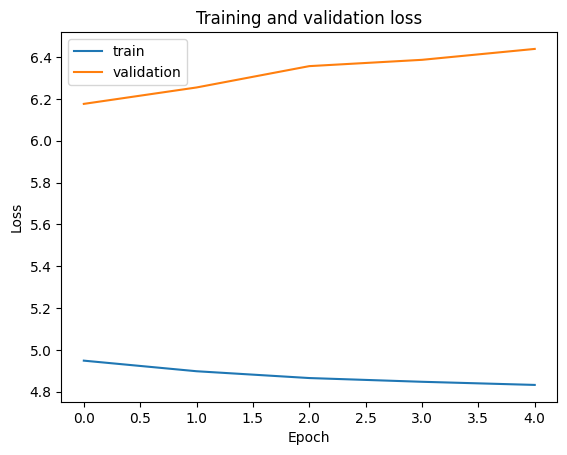

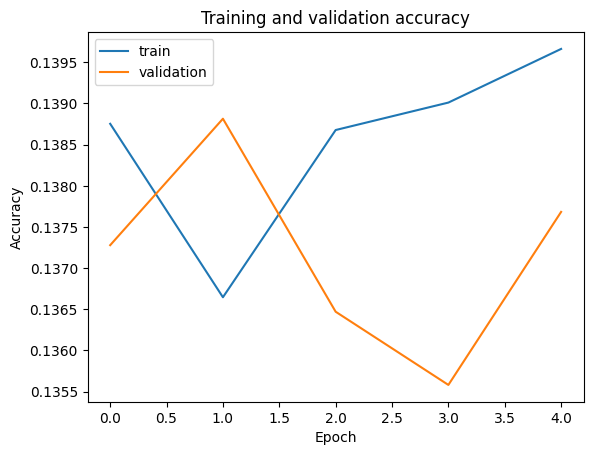


Error while plotting results: 'perplexity'


In [24]:
def run_everything():
    from pickle import load
    from keras.models import load_model
    import os

    SEED_TEXT = "today was such a sad day. i really wanted to go and meet harry. he helped me so much with my homework."
    SEQUENCE_LENGTH = 30
    EPOCHS = 20
    BATCH_SIZE = 128
    EMBEDDING_DIM = 50
    LR = 0.001
    NUM_WORDS_TO_GENERATE = 30

    # # merge all the data
    # merge_txt_files(input_dir='./database/hp_unprocessed',
    #                 output_dir='database/merged/', name='hp_unprocessed_merged.txt')

    FILE_NAME = 'hpBook1.txt'
    # read the data
    text = read_txt_file(file_name= FILE_NAME,
                         folder_path='/content/drive/MyDrive/PredictNextWords/database/hp_unprocessed')

    # preprocess the data
    preprocessed_tokens = data_preprocessing(text, save_file=f'{FILE_NAME}_processed', directory='/content/drive/MyDrive/PredictNextWords/database/processed/', verbose=True, remove_stopwords=False,
                                             lemmatize=True,  to_remove_emojis=False, to_correct_typos=False)

    del text

    # # create the word to index mappings
    word_index, index_word, text_tokenized = get_word_to_index_mappings(
        preprocessed_tokens)

    # # # get the features and targets
    features, targets = get_features_targets(
        text_tokenized, total_unique_tokens=len(word_index)+1, seq_len=SEQUENCE_LENGTH)

    #save features, targets in df file
    import pandas as pd
    df = pd.DataFrame({'features': features, 'targets': targets})
    df.to_csv('features_targets.csv', index=False)
    del df

    # # # split the data into training, testing and validation sets
    X_train, X_test, X_val, y_train, y_test, y_val = split_training_testing_validation(
        features, targets, test_size=0.05, val_size=0.15)

    embedding_matrix = load_glove(word_index, embedding_dim=EMBEDDING_DIM)

    print(
        f"\nSEQUENCE_LENGTH: {SEQUENCE_LENGTH}, EPOCHS: {EPOCHS}, BATCH_SIZE: {BATCH_SIZE}, EMBEDDING_DIM: {EMBEDDING_DIM}, LR: {LR}")

    model, history = train_lstm(word_index, embedding_matrix, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, embedding_dim=EMBEDDING_DIM,
                                seq_len=SEQUENCE_LENGTH, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, X_test=X_test, y_test=y_test)
    model.save_weights('weights.h5')


    tokenizer = load(open('tokenizer.pkl', 'rb'))
    model_name = f'lstm_{EMBEDDING_DIM}d_{SEQUENCE_LENGTH}seq_{EPOCHS}epochs_{LR}lr_{BATCH_SIZE}batch.h5'
    saved_model_dir = 'saved_models'
    # model_loaded = load_model(os.path.join(
    #     saved_model_dir, model_name))
    model_loaded = load_model(os.path.join(
        saved_model_dir, model_name), custom_objects={'perplexity': perplexity})
    history_loaded = load(open(os.path.join(
        saved_model_dir, f'lstm_{EMBEDDING_DIM}d_{SEQUENCE_LENGTH}seq_{EPOCHS}epochs_{LR}lr_{BATCH_SIZE}batch_history.pkl'), 'rb'))

    generated_seq = generate_seq(
        model_loaded, tokenizer, SEQUENCE_LENGTH, seed_text=SEED_TEXT, n_words=NUM_WORDS_TO_GENERATE)
    print(f'\nGenerating text...\nInput: {SEED_TEXT}. \nGenerated text: {generated_seq}\n')

    try:
        plot_results(history_loaded)
    except Exception as e:
        print(f"\nError while plotting results: {e}")


if __name__ == '__main__':
    run_everything()

In [25]:
# def run_everything():
#     from pickle import load
#     from keras.models import load_model
#     import os

#     SEED_TEXT = "today was such a sad day. i really wanted to go and meet harry. he helped me so much with my homework."
#     SEQUENCE_LENGTH = 30
#     EPOCHS = 20
#     BATCH_SIZE = 128
#     EMBEDDING_DIM = 50
#     LR = 0.001
#     NUM_WORDS_TO_GENERATE = 30

#     # # merge all the data
#     # merge_txt_files(input_dir='./database/hp_unprocessed',
#     #                 output_dir='database/merged/', name='hp_unprocessed_merged.txt')

#     FILE_NAME = 'hpBook1.txt'
#     # read the data
#     text = read_txt_file(file_name= FILE_NAME,
#                          folder_path='/content/drive/MyDrive/PredictNextWords/database/hp_unprocessed')

#     # preprocess the data
#     preprocessed_tokens = data_preprocessing(text, save_file=f'{FILE_NAME}_processed', directory='/content/drive/MyDrive/PredictNextWords/database/processed/', verbose=True, remove_stopwords=False,
#                                              lemmatize=True,  to_remove_emojis=False, to_correct_typos=False)

#     del text

#     # # create the word to index mappings
#     word_index, index_word, text_tokenized = get_word_to_index_mappings(
#         preprocessed_tokens)

#     # # # get the features and targets
#     features, targets = get_features_targets(
#         text_tokenized, total_unique_tokens=len(word_index)+1, seq_len=SEQUENCE_LENGTH)

#     #save features, targets in df file
#     import pandas as pd
#     df = pd.DataFrame({'features': features, 'targets': targets})
#     df.to_csv('features_targets.csv', index=False)
#     del df

#     # # # split the data into training, testing and validation sets
#     X_train, X_test, X_val, y_train, y_test, y_val = split_training_testing_validation(
#         features, targets, test_size=0.05, val_size=0.15)

#     embedding_matrix = load_glove(word_index, embedding_dim=EMBEDDING_DIM)

#     print(
#         f"\nSEQUENCE_LENGTH: {SEQUENCE_LENGTH}, EPOCHS: {EPOCHS}, BATCH_SIZE: {BATCH_SIZE}, EMBEDDING_DIM: {EMBEDDING_DIM}, LR: {LR}")

#     model, history = train_lstm(word_index, embedding_matrix, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, embedding_dim=EMBEDDING_DIM,
#                                 seq_len=SEQUENCE_LENGTH, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, X_test=X_test, y_test=y_test)



#     tokenizer = load(open('tokenizer.pkl', 'rb'))
#     model_name = f'lstm_{EMBEDDING_DIM}d_{SEQUENCE_LENGTH}seq_{EPOCHS}epochs_{LR}lr_{BATCH_SIZE}batch.h5'
#     saved_model_dir = 'saved_models'
#     model_loaded = load_model(os.path.join(
#         saved_model_dir, model_name))
#     # model_loaded = load_model(os.path.join(
#     #     saved_model_dir, model_name), custom_objects={'perplexity': perplexity})
#     history_loaded = load(open(os.path.join(
#         saved_model_dir, f'lstm_{EMBEDDING_DIM}d_{SEQUENCE_LENGTH}seq_{EPOCHS}epochs_{LR}lr_{BATCH_SIZE}batch_history.pkl'), 'rb'))

#     generated_seq = generate_seq(
#         model_loaded, tokenizer, SEQUENCE_LENGTH, seed_text=SEED_TEXT, n_words=NUM_WORDS_TO_GENERATE)
#     print(f'\nGenerating text...\nInput: {SEED_TEXT}. \nGenerated text: {generated_seq}\n')

#     try:
#         plot_results(history_loaded)
#     except Exception as e:
#         print(f"\nError while plotting results: {e}")


# if __name__ == '__main__':
#     run_everything()